# DIFA-Projekt Prognose mit Entscheidungsbäumen
**Commitments-of-Traders-Berichte**



Wie lässt sich mithilfe eines Entscheidungsbaums auf Basis ausgewählter CoT-Kennzahlen prognostizieren, ob der Goldpreis in der jeweils folgenden Woche steigt oder fällt?



**Abgabe**: 28. Dezember 2025

**Dozent**:Prof. Dr. Raúl Diego Gimeno


**Studierende**: Ariana Formuli

In [1]:

!pip install pycountry
!pip install openpyxl

# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycountry as pyc
import seaborn as sns
import requests
import io

from functools import reduce
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve


# Setzen des Anzeigeformats für Fliesskommazahlen (floats) auf zwei Dezimalstellen
pd.options.display.float_format = '{:.2f}'.format

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.6 MB/s eta 0:00:00


In [2]:
#etwas schönere Standard-Einstellungen für Plots
plt.rcParams["figure.dpi"] = 130
plt.rcParams["font.size"] = 10

 # 1)  URL zur Excel-Datei mit CoT-Daten 2023 und 2024 aus dem GitHub-Repository

In [4]:
!git clone https://github.com/Forabash/DIFA.git

Cloning into 'DIFA'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 8.31 MiB | 4.66 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [5]:
cot23 = pd.read_excel("/content/DIFA/CoT_Daten2023.xls")
cot23.head()


,Market_and_Exchange_Names,As_of_Date_In_Form_YYMMDD,Report_Date_as_MM_DD_YYYY,CFTC_Contract_Market_Code,CFTC_Market_Code,CFTC_Region_Code,CFTC_Commodity_Code,Open_Interest_All,Prod_Merc_Positions_Long_ALL,Prod_Merc_Positions_Short_ALL,...,Conc_Gross_LE_4_TDR_Short_Other,Conc_Gross_LE_8_TDR_Long_Other,Conc_Gross_LE_8_TDR_Short_Other,Conc_Net_LE_4_TDR_Long_Other,Conc_Net_LE_4_TDR_Short_Other,Conc_Net_LE_8_TDR_Long_Other,Conc_Net_LE_8_TDR_Short_Other,Contract_Units,CFTC_SubGroup_Code,FutOnly_or_Combined
0,WHEAT-SRW - CHICAGO BOARD OF TRADE,231226,2023-12-26,001602,CBT,0,1,362050,56723,77340,...,34.00,43.00,45.90,26.00,33.70,43.00,42.40,"(CONTRACTS OF 5,000 BUSHELS)",A10,FutOnly
1,WHEAT-SRW - CHICAGO BOARD OF TRADE,231219,2023-12-19,001602,CBT,0,1,351349,58325,75073,...,33.30,44.80,44.20,26.70,32.10,44.50,40.60,"(CONTRACTS OF 5,000 BUSHELS)",A10,FutOnly
2,WHEAT-SRW - CHICAGO BOARD OF TRADE,231212,2023-12-12,001602,CBT,0,1,347460,58617,70308,...,33.30,45.30,44.70,28.10,31.30,44.90,41.20,"(CONTRACTS OF 5,000 BUSHELS)",A10,FutOnly
3,WHEAT-SRW - CHICAGO BOARD OF TRADE,231205,2023-12-05,001602,CBT,0,1,405309,82691,70921,...,31.50,46.10,44.90,29.70,31.20,45.70,42.20,"(CONTRACTS OF 5,000 BUSHELS)",A10,FutOnly
4,WHEAT-SRW - CHICAGO BOARD OF TRADE,231128,2023-11-28,001602,CBT,0,1,411837,82372,52475,...,26.80,47.80,40.80,32.50,25.40,47.80,37.50,"(CONTRACTS OF 5,000 BUSHELS)",A10,FutOnly


In [6]:
cot24 = pd.read_excel("/content/DIFA/CoT_Daten2024.xls")
cot24.head()

,Market_and_Exchange_Names,As_of_Date_In_Form_YYMMDD,Report_Date_as_MM_DD_YYYY,CFTC_Contract_Market_Code,CFTC_Market_Code,CFTC_Region_Code,CFTC_Commodity_Code,Open_Interest_All,Prod_Merc_Positions_Long_ALL,Prod_Merc_Positions_Short_ALL,...,Conc_Gross_LE_4_TDR_Short_Other,Conc_Gross_LE_8_TDR_Long_Other,Conc_Gross_LE_8_TDR_Short_Other,Conc_Net_LE_4_TDR_Long_Other,Conc_Net_LE_4_TDR_Short_Other,Conc_Net_LE_8_TDR_Long_Other,Conc_Net_LE_8_TDR_Short_Other,Contract_Units,CFTC_SubGroup_Code,FutOnly_or_Combined
0,WHEAT-SRW - CHICAGO BOARD OF TRADE,241231,2024-12-31,001602,CBT,0,1,460417,72875,58349,...,30.90,37.30,43.70,22.90,30.80,36.90,43.40,"(CONTRACTS OF 5,000 BUSHELS)",A10,FutOnly
1,WHEAT-SRW - CHICAGO BOARD OF TRADE,241224,2024-12-24,001602,CBT,0,1,460438,83339,58843,...,26.90,38.70,40.30,23.60,26.80,38.20,39.50,"(CONTRACTS OF 5,000 BUSHELS)",A10,FutOnly
2,WHEAT-SRW - CHICAGO BOARD OF TRADE,241217,2024-12-17,001602,CBT,0,1,444238,80625,65017,...,26.20,41.80,39.80,25.20,26.10,41.40,38.20,"(CONTRACTS OF 5,000 BUSHELS)",A10,FutOnly
3,WHEAT-SRW - CHICAGO BOARD OF TRADE,241210,2024-12-10,001602,CBT,0,1,425812,76047,76375,...,26.30,43.10,40.00,26.00,26.30,42.60,39.00,"(CONTRACTS OF 5,000 BUSHELS)",A10,FutOnly
4,WHEAT-SRW - CHICAGO BOARD OF TRADE,241203,2024-12-03,001602,CBT,0,1,423678,72495,71171,...,27.50,45.90,41.70,28.20,27.50,45.40,40.30,"(CONTRACTS OF 5,000 BUSHELS)",A10,FutOnly


In [7]:
# Nur Gold aus jeder Datei filtern
market_name = "GOLD - COMMODITY EXCHANGE INC."

gold23 = cot23[cot23["Market_and_Exchange_Names"] == market_name].copy()
gold24 = cot24[cot24["Market_and_Exchange_Names"] == market_name].copy()

# Zusammenführen
cot = pd.concat([gold23, gold24], ignore_index=True)

# Datum setzen
cot["date"] = pd.to_datetime(cot["Report_Date_as_MM_DD_YYYY"])
cot = cot.sort_values("date").reset_index(drop=True)

print("Anzahl CoT-Beobachtungen (nur Gold):", len(cot))
cot[["Market_and_Exchange_Names", "date"]].tail()

Anzahl CoT-Beobachtungen (nur Gold): 105


,Market_and_Exchange_Names,date
100,GOLD - COMMODITY EXCHANGE INC.,2024-12-03
101,GOLD - COMMODITY EXCHANGE INC.,2024-12-10
102,GOLD - COMMODITY EXCHANGE INC.,2024-12-17
103,GOLD - COMMODITY EXCHANGE INC.,2024-12-24
104,GOLD - COMMODITY EXCHANGE INC.,2024-12-31


#2) Gold-Preise (GC=F) für diesen Zeitraum (2023-2024) aus Yahoo Finance holen


In [8]:

!pip install yfinance
import yfinance as yf

In [9]:

# Gold-Future GC=F, NUR 2023–2024
prices = yf.download("GC=F", start="2023-01-01", end="2025-01-01", interval="1d")

# Index (Datum) zu Spalte machen
prices = prices.reset_index()

# Falls MultiIndex-Spalten vorhanden sind → eine Ebene machen
if isinstance(prices.columns, pd.MultiIndex):
    prices.columns = prices.columns.get_level_values(0)

# Datumsspalte benennen
if "Date" in prices.columns:
    prices = prices.rename(columns={"Date": "date"})
elif "index" in prices.columns:
    prices = prices.rename(columns={"index": "date"})

# Schlusskurs-Spalte nach "close" benennen
if "Adj Close" in prices.columns:
    prices["close"] = prices["Adj Close"]
elif "Close" in prices.columns:
    prices["close"] = prices["Close"]
else:
    raise ValueError("Keine 'Adj Close' oder 'Close'-Spalte in prices gefunden.")

prices = prices[["date", "close"]].sort_values("date").reset_index(drop=True)

print("Anzahl Preis-Beobachtungen:", len(prices))
prices.head()
prices.tail()

/tmp/ipython-input-796066161.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download("GC=F", start="2023-01-01", end="2025-01-01", interval="1d")
[*********************100%***********************]  1 of 1 completed

Anzahl Preis-Beobachtungen: 502


Price,date,close
497,2024-12-24,2620.00
498,2024-12-26,2638.80
499,2024-12-27,2617.20
500,2024-12-30,2606.10
501,2024-12-31,2629.20


#3) CoT-Features für den Entscheidungsbaum

In [10]:

cot = cot.sort_values("date").reset_index(drop=True)
# Netto-Positionen
cot["net_mm"]   = cot["M_Money_Positions_Long_ALL"] - cot["M_Money_Positions_Short_ALL"]
cot["net_pmpu"] = cot["Prod_Merc_Positions_Long_ALL"] - cot["Prod_Merc_Positions_Short_ALL"]
cot["net_swap"] = cot["Swap_Positions_Long_All"]     - cot["Swap__Positions_Short_All"]

# Prozentanteile Managed Money
cot["pct_mm_long"]  = cot["Pct_of_OI_M_Money_Long_All"]
cot["pct_mm_short"] = cot["Pct_of_OI_M_Money_Short_All"]

# Veränderungen zur Vorwoche
cot["chg_net_mm"]      = cot["net_mm"].diff()
cot["chg_pct_mm_long"] = cot["pct_mm_long"].diff()

# Z-Score der Managed-Money-Netto-Position (für Extreme)
window = 13 # ca. ein Quartal
rolling_mean = cot["net_mm"].rolling(window).mean()
rolling_std  = cot["net_mm"].rolling(window).std()
(cot["z_net_mm"])= (cot["net_mm"] - rolling_mean) / rolling_std
print (cot["z_net_mm"])


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
100   -0.59
101    0.18
102   -0.36
103   -1.20
104   -1.03
Name: z_net_mm, Length: 105, dtype: float64


# 4) Merge: CoT (wöchentlich) + Goldpreis (wöchentlich)

In [11]:
# prices hat: date, close (daily)
prices = prices.sort_values("date").reset_index(drop=True)

# Weekly-Resampling: eine Beobachtung pro Woche, z.B. Dienstags-Schluss
prices_w = prices.set_index("date").resample("W-TUE").last().reset_index()

print("Anzahl wöchentliche Preis-Beobachtungen:", len(prices_w))
prices_w.tail()


Anzahl wöchentliche Preis-Beobachtungen: 105


Price,date,close
100,2024-12-03,2644.70
101,2024-12-10,2697.60
102,2024-12-17,2644.40
103,2024-12-24,2620.00
104,2024-12-31,2629.20


In [12]:
# CoT (wöchentlich) mit Goldpreis (wöchentlich) verknüpfen
# statt prices: prices_w benutzen
data = pd.merge_asof(
    cot.sort_values("date"),
    prices_w.sort_values("date"),
    on="date",
    direction="nearest"  t
)

data = data.sort_values("date").reset_index(drop=True)

# Zielvariable wie gehabt: Rendite bis zum nächsten Bericht
data["close_fwd_1w"] = data["close"].shift(-1)
data["ret_fwd_1w"]   = data["close_fwd_1w"] / data["close"] - 1
data["y"] = (data["ret_fwd_1w"] > 0).astype(int)

features = [
    "net_mm", "net_pmpu", "net_swap",
    "pct_mm_long", "pct_mm_short",
    "chg_net_mm", "chg_pct_mm_long",
    "z_net_mm"
]

# NaNs durch Rolling/Diff entfernen
data = data.dropna(subset=features + ["y"]).copy()

print("Anzahl Beobachtungen gesamt:", len(data))
data[["date", "y"]].tail()

Anzahl Beobachtungen gesamt: 93


,date,y
100,2024-12-03,1
101,2024-12-10,0
102,2024-12-17,0
103,2024-12-24,1
104,2024-12-31,0


#5) 70 % Training / 30 % Test  - ZEITLICH

In [13]:

n = len(data)
split_idx = int(n * 0.7)   # erste 70 % Training, letzte 30 % Test

train = data.iloc[:split_idx].copy()
test  = data.iloc[split_idx:].copy()

X_train, y_train = train[features], train["y"]
X_test,  y_test  = test[features],  test["y"]

print("Gesamt-Beobachtungen:", n)
print("Train:", len(X_train))
print("Test:", len(X_test))
print("Train-Zeitraum:", train["date"].min(), "bis", train["date"].max())
print("Test-Zeitraum:",  test["date"].min(),  "bis", test["date"].max())


Gesamt-Beobachtungen: 93
Train: 65
Test: 28
Train-Zeitraum: 2023-03-28 00:00:00 bis 2024-06-18 00:00:00
Test-Zeitraum: 2024-06-25 00:00:00 bis 2024-12-31 00:00:00


#6) Modell: Entscheidungsbaum trainieren (Prognose)

In [14]:
tree = DecisionTreeClassifier(
    max_depth=3,        # begrenzte Tiefe = bessere Interpretierbarkeit
    min_samples_leaf=3,
    random_state=42
)
tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred  = tree.predict(X_test)

#7) Bewertung: Accuracy, Baseline, Precision, Recall, F1

In [27]:
# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test,  y_test_pred)

print("\nTrain-Accuracy:", round(train_acc, 3))
print("Test-Accuracy:", round(test_acc, 3))

# Baseline: immer die häufigere Klasse im Test vorhersagen
p1_test = y_test.mean()  # Anteil "steigt"
baseline_acc = max(p1_test, 1 - p1_test)
print("Baseline-Accuracy (Mehrheitsklasse im Test):", round(baseline_acc, 3))

# Confusion Matrix
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

# Precision, Recall, F1 je Klasse
print("\nKlassifikationsbericht (Test):")
print(classification_report(y_test, y_test_pred))

# Entscheidungsregeln als Text
rules = export_text(tree, feature_names=features)
print("\nRegeln des Entscheidungsbaums (nur Goldmarkt):")
print(rules)


Train-Accuracy: 0.723
Test-Accuracy: 0.571
Baseline-Accuracy (Mehrheitsklasse im Test): 0.643

Confusion Matrix (Test):
[[ 2  8]
 [ 4 14]]

Klassifikationsbericht (Test):
              precision    recall  f1-score   support

           0       0.33      0.20      0.25        10
           1       0.64      0.78      0.70        18

    accuracy                           0.57        28
   macro avg       0.48      0.49      0.47        28
weighted avg       0.53      0.57      0.54        28


Regeln des Entscheidungsbaums (nur Goldmarkt):
|--- pct_mm_long <= 25.15
|   |--- class: 1
|--- pct_mm_long >  25.15
|   |--- net_pmpu <= -27292.00
|   |   |--- z_net_mm <= 1.43
|   |   |   |--- class: 1
|   |   |--- z_net_mm >  1.43
|   |   |   |--- class: 0
|   |--- net_pmpu >  -27292.00
|   |   |--- net_mm <= 36906.50
|   |   |   |--- class: 0
|   |   |--- net_mm >  36906.50
|   |   |   |--- class: 0



#8) Visualisierung: Entscheidungsbaum

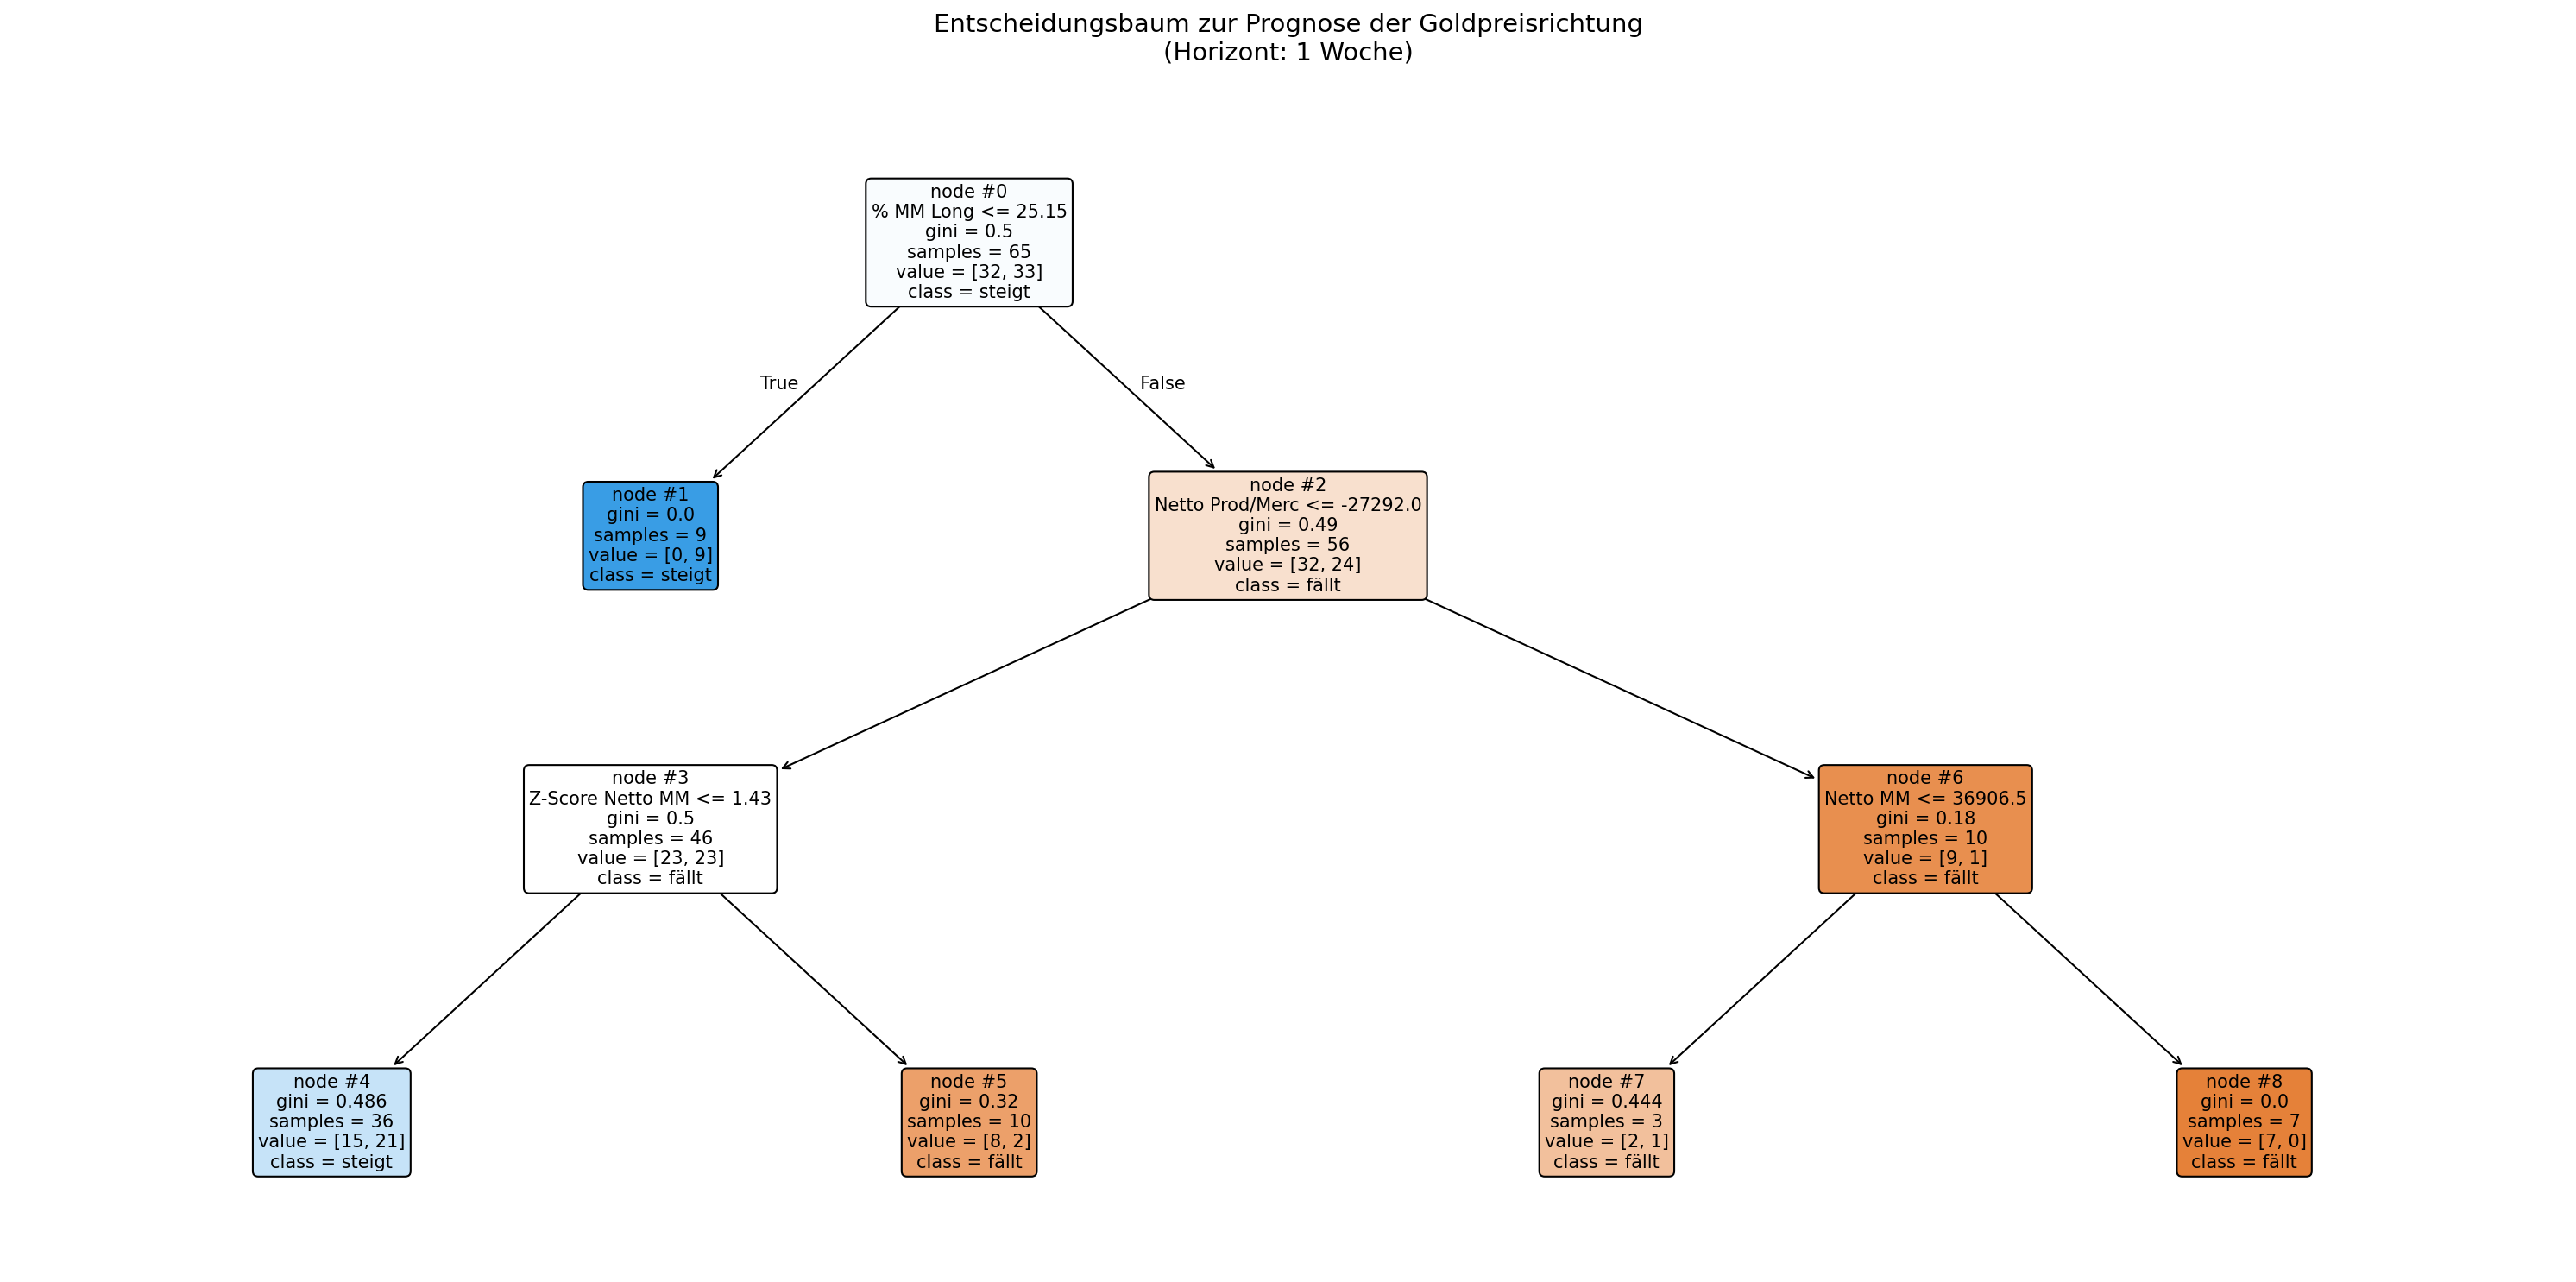

In [16]:

pretty_names = {
    "net_mm": "Netto MM",
    "net_pmpu": "Netto Prod/Merc",
    "net_swap": "Netto Swap",
    "pct_mm_long": "% MM Long",
    "pct_mm_short": "% MM Short",
    "chg_net_mm": "Δ Netto MM",
    "chg_pct_mm_long": "Δ % MM Long",
    "z_net_mm": "Z-Score Netto MM"
}

pretty_features = [pretty_names[f] for f in features]

# Grösseres, hochauflösendes Bild
fig, ax = plt.subplots(figsize=(20, 10), dpi=150)

plot_tree(
    tree,
    feature_names=pretty_features,
    class_names=["fällt", "steigt"],
    filled=True,
    rounded=True,
    fontsize=10,
    ax=ax,
    impurity=True,    # gini anzeigen
    node_ids=True     # Knotennummern für die Beschreibung im Text
)

ax.set_title(
    "Entscheidungsbaum zur Prognose der Goldpreisrichtung\n"
    "(Horizont: 1 Woche)",
    fontsize=14,
    pad=20
)

plt.tight_layout()
plt.show()

#9) Visualisierung: Feature Importance

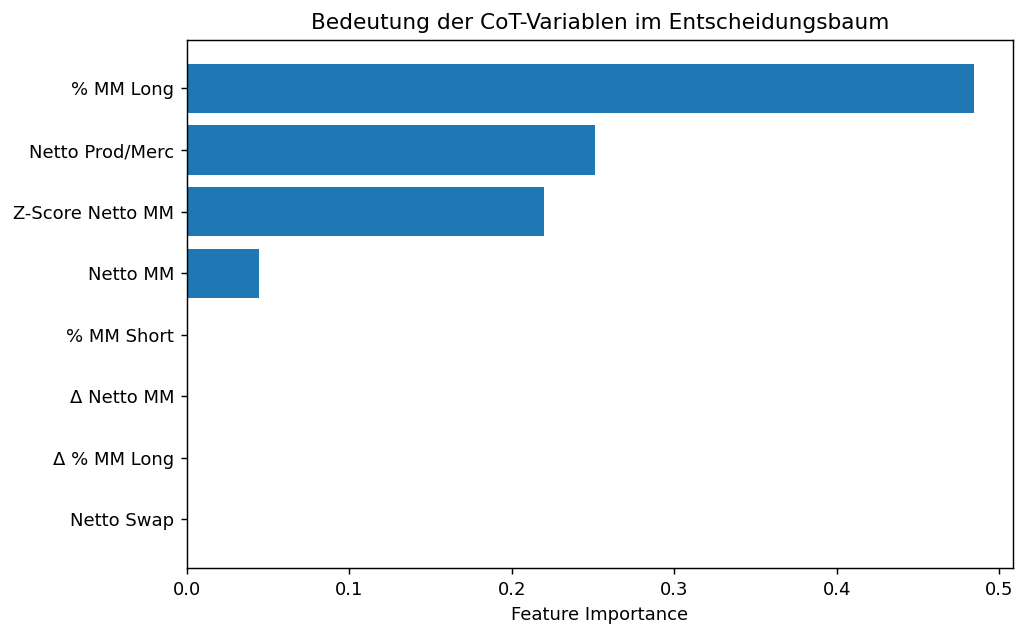

In [17]:
importances = tree.feature_importances_
idx = np.argsort(importances)  # aufsteigend sortieren

plt.figure(figsize=(8, 5))
plt.barh(
    [pretty_features[i] for i in idx],
    importances[idx]
)
plt.xlabel("Feature Importance")
plt.title("Bedeutung der CoT-Variablen im Entscheidungsbaum")
plt.tight_layout()
plt.show()

#10) Visualisierung: Confusion Matrix (Test)

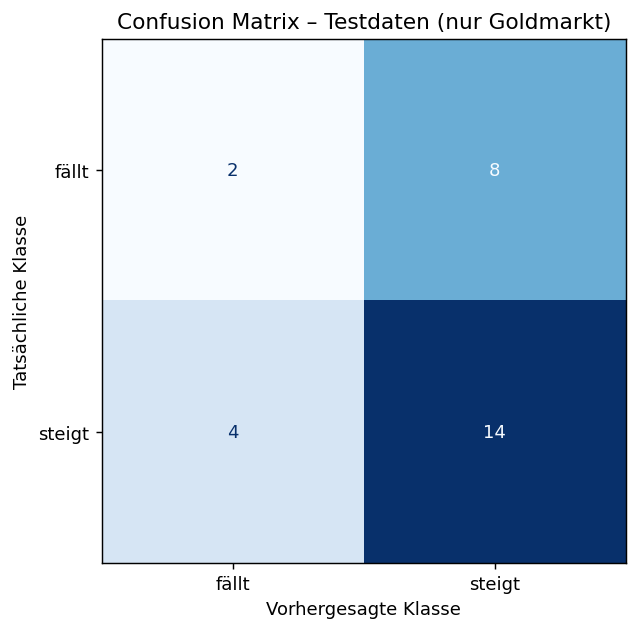

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_estimator(
    tree,
    X_test,
    y_test,
    display_labels=["fällt", "steigt"],
    cmap="Blues",
    colorbar=False,
    ax=ax
)
ax.set_title("Confusion Matrix – Testdaten (nur Goldmarkt)")
ax.set_xlabel("Vorhergesagte Klasse")
ax.set_ylabel("Tatsächliche Klasse")
plt.tight_layout()
plt.show()

#11) Overfitting-/Underfitting-Analyse


Accuracy nach Baumtiefe:
   depth  train_acc  test_acc
0      1       0.63      0.36
1      2       0.63      0.36
2      3       0.72      0.57
3      4       0.75      0.39
4      5       0.83      0.39
5      6       0.88      0.36
6      7       0.88      0.36
7      8       0.92      0.39


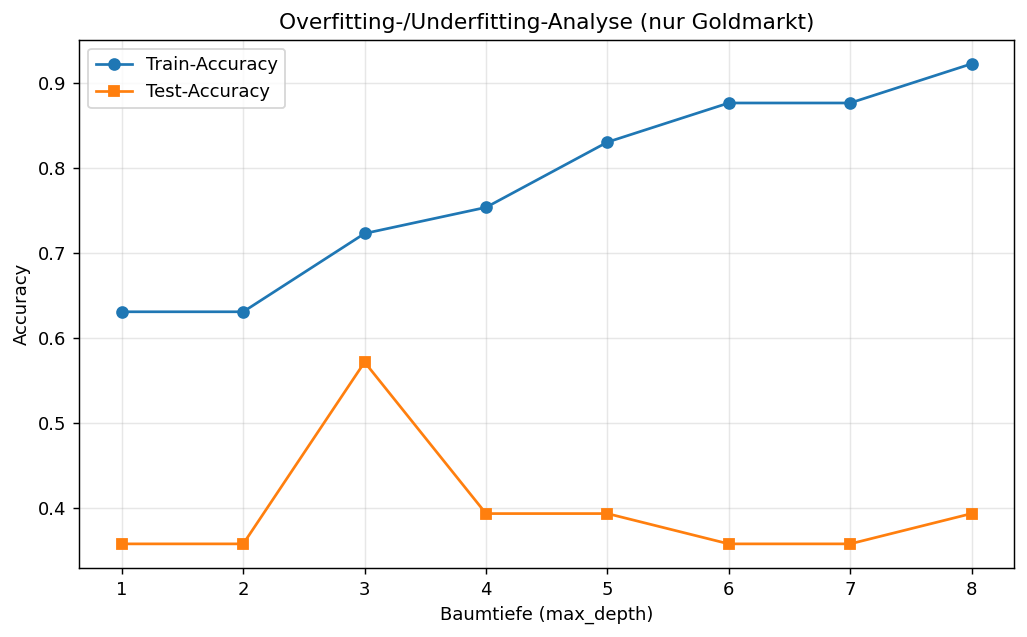

In [19]:
results = []
for depth in range(1, 9):  # Baumtiefe 1–8
    clf = DecisionTreeClassifier(
        max_depth=depth,
        min_samples_leaf=3,
        random_state=42
    )
    clf.fit(X_train, y_train)
    y_tr = clf.predict(X_train)
    y_te = clf.predict(X_test)
    results.append({
        "depth": depth,
        "train_acc": accuracy_score(y_train, y_tr),
        "test_acc":  accuracy_score(y_test,  y_te)
    })

res_df = pd.DataFrame(results)
print("\nAccuracy nach Baumtiefe:")
print(res_df)

plt.figure(figsize=(8, 5))
plt.plot(res_df["depth"], res_df["train_acc"], marker="o", label="Train-Accuracy")
plt.plot(res_df["depth"], res_df["test_acc"],  marker="s", label="Test-Accuracy")
plt.xlabel("Baumtiefe (max_depth)")
plt.ylabel("Accuracy")
plt.title("Overfitting-/Underfitting-Analyse (nur Goldmarkt)")
plt.xticks(res_df["depth"])
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

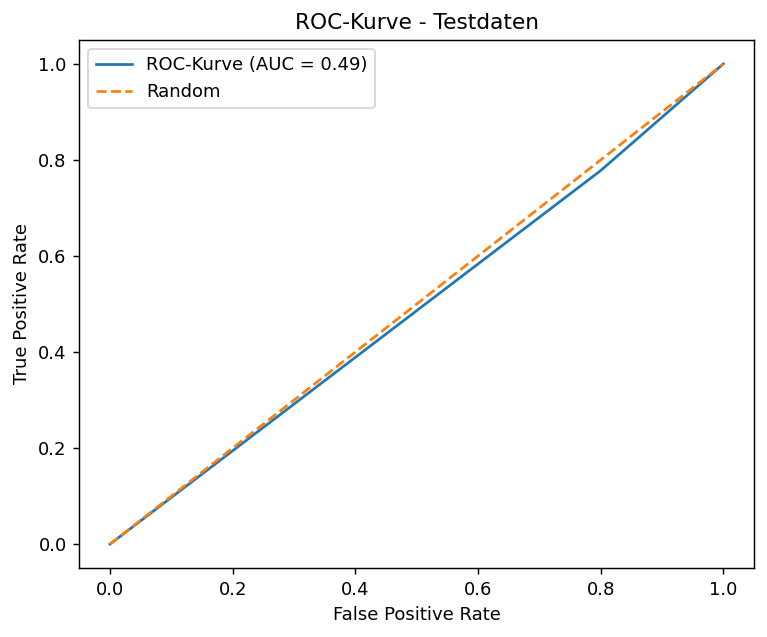

In [25]:
# Wahrscheinlichkeiten für Klasse 1 (= "steigt")
y_score = tree.predict_proba(X_test)[:, 1]

# ROC-Kurve berechnen
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC-Kurve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Kurve - Testdaten")
plt.legend()
plt.tight_layout()
plt.show()

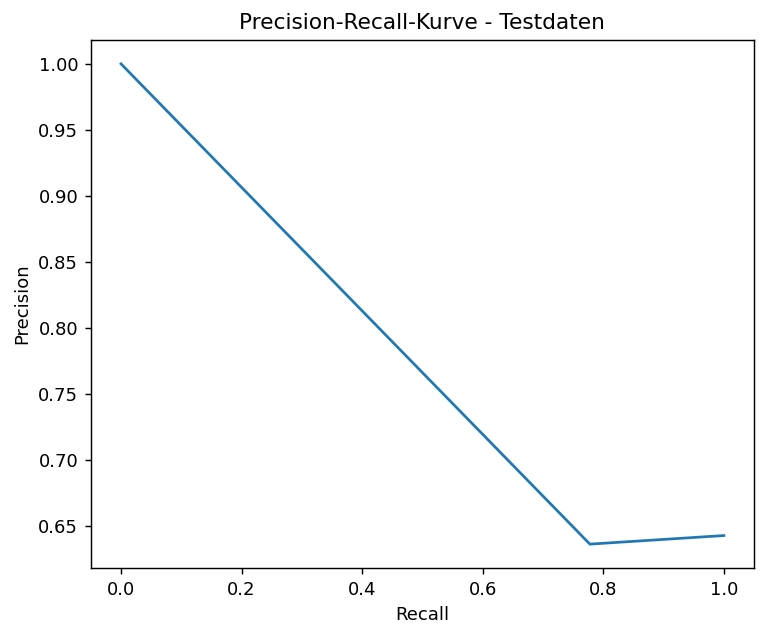

In [26]:
prec, rec, _ = precision_recall_curve(y_test, y_score)

plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall-Kurve - Testdaten")
plt.tight_layout()
plt.show()

In [22]:
# Klassenverteilung prüfen
print("Verteilung y gesamt:")
print(data["y"].value_counts())
print("Anteil Klasse 1 (steigt):", data["y"].mean().round(3))

print("\nTrain/Test-Verteilung:")
print("Train:", y_train.value_counts())
print("Test:", y_test.value_counts())

# Baseline: immer Mehrheitsklasse im Testjahr
baseline = max(y_test.mean(), 1 - y_test.mean())
print("\nBaseline-Accuracy (immer häufigste Klasse):", baseline.round(3))

Verteilung y gesamt:
y
1    51
0    42
Name: count, dtype: int64
Anteil Klasse 1 (steigt): 0.548

Train/Test-Verteilung:
Train: y
1    33
0    32
Name: count, dtype: int64
Test: y
1    18
0    10
Name: count, dtype: int64

Baseline-Accuracy (immer häufigste Klasse): 0.643


In [23]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd

# TimeSeriesSplit mit z.B. 5 Folds (expanding window)
tscv = TimeSeriesSplit(n_splits=5)

depths = [2, 3, 4, 5]   # Kandidaten für max_depth
cv_results = []

for depth in depths:
    fold_accuracies = []
    fold_f1s = []

    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clf = DecisionTreeClassifier(
            max_depth=depth,
            min_samples_leaf=3,
            random_state=42
        )
        clf.fit(X_tr, y_tr)
        y_val_pred = clf.predict(X_val)

        fold_accuracies.append(accuracy_score(y_val, y_val_pred))
        fold_f1s.append(f1_score(y_val, y_val_pred))

    cv_results.append({
        "max_depth": depth,
        "cv_acc_mean": np.mean(fold_accuracies),
        "cv_acc_std":  np.std(fold_accuracies),
        "cv_f1_mean":  np.mean(fold_f1s),
        "cv_f1_std":   np.std(fold_f1s),
    })

cv_df = pd.DataFrame(cv_results)
print(cv_df)

   max_depth  cv_acc_mean  cv_acc_std  cv_f1_mean  cv_f1_std
0          2         0.48        0.23        0.42       0.30
1          3         0.50        0.18        0.48       0.27
2          4         0.52        0.13        0.52       0.16
3          5         0.56        0.15        0.58       0.18


<function matplotlib.pyplot.show(close=None, block=None)>

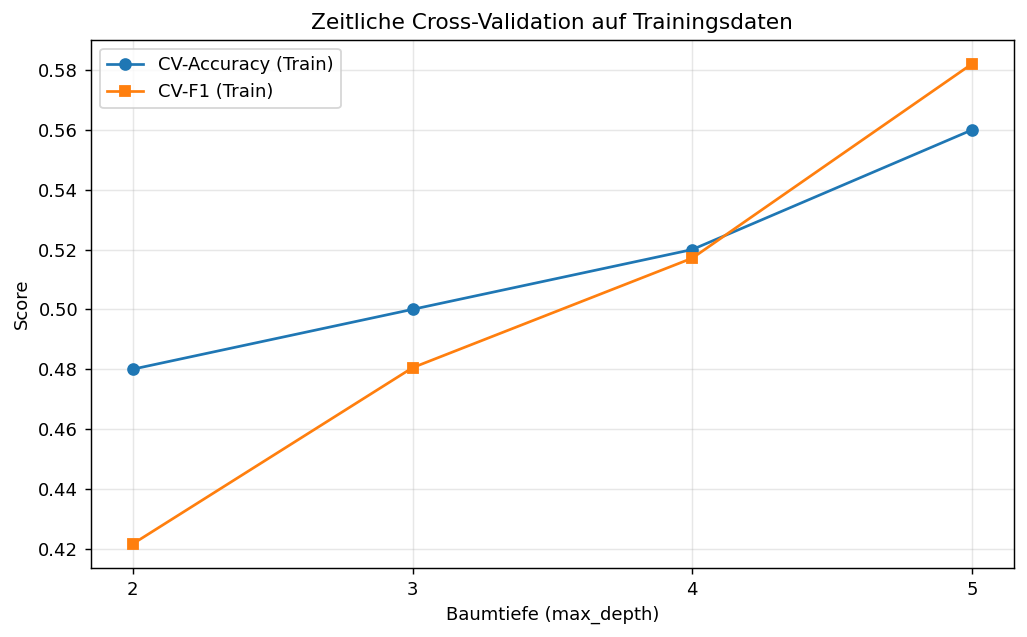

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(cv_df["max_depth"], cv_df["cv_acc_mean"], marker="o", label="CV-Accuracy (Train)")
plt.plot(cv_df["max_depth"], cv_df["cv_f1_mean"],  marker="s", label="CV-F1 (Train)")
plt.xlabel("Baumtiefe (max_depth)")
plt.ylabel("Score")
plt.title("Zeitliche Cross-Validation auf Trainingsdaten")
plt.xticks(cv_df["max_depth"])
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show